In [1]:
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
from math import e
import pymc3 as pm
import theano.tensor as T
import graphviz
import arviz as az

In [2]:
url = 'https://raw.githubusercontent.com/felipeisj/info274-2021/main/billonarios.csv?token=AGNHGUQCDLCBZVYN6QQEFNDA6ZOHG'
datos = pd.read_csv(url)

In [3]:
x = datos[['logpibpc', 'logpob', 'gatt']].to_numpy()
y = datos[['nbillonarios']].to_numpy()

#Definición del modelo


In [40]:
with pm.Model() as funcion_poisson:

    # define priors, weakly informative Normal
    b0 = pm.Normal('theta0', mu=0, sd=10, shape=())
    b1 = pm.Normal("logpibpc", mu=0, sd=8, shape=())
    b2 = pm.Normal("logpob", mu=0, sd=15, shape=())
    b3 = pm.Normal("gatt", mu=0, sd=25, shape=())

    # define linear model and exp link function
    theta = (
        b0
        + b1 * datos["logpibpc"]
        + b2 * datos["logpob"]
        + b3 * datos["gatt"]
    )
    
    #Variable Determinista
    mu = pm.Deterministic("mu", theta)
    
    ## Verosimilitud de Poisson
    poiss = pm.Poisson("poiss", mu=np.exp(mu), observed=y.T[0])

# Despliegue de forma del modelo

In [41]:
funcion_poisson

[theta0 ~ Normal, logpibpc ~ Normal, logpob ~ Normal, gatt ~ Normal]

[mu ~ Deterministic]

[poiss ~ Poisson]

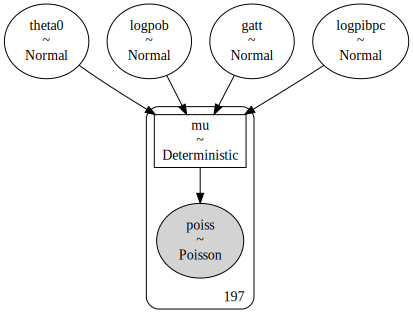

In [42]:
# Printea los Priors
display(funcion_poisson.free_RVs)
# Printea variable determinista
display(funcion_poisson.deterministics)
# Printea variable observada
display(funcion_poisson.observed_RVs)
pm.model_to_graphviz(funcion_poisson)

In [43]:
with funcion_poisson:
  prior_checks = pm.sample_prior_predictive(samples = 100, var_names = ['theta0', 'logpibpc', 'logpob', 'gatt'])

In [46]:
(prior_checks['logpibpc'])

array([ 4.89292699e+00, -7.48802999e+00, -1.01285582e+00, -2.05140822e-01,
       -4.03246856e+00, -2.63514397e+00, -3.82147609e+00,  1.01389473e+01,
        6.29476649e+00,  4.88007460e+00,  4.45859811e+00,  6.41965702e-01,
        1.21151232e+01,  7.28558004e+00,  3.37542481e-01, -9.86791571e-01,
        4.08657862e+00, -1.04298085e+00, -1.51245611e+01, -3.08161976e+00,
        1.22288895e+01, -4.29374917e+00,  8.85405583e+00,  5.35767913e+00,
       -4.32694911e+00, -7.76501255e+00, -7.50164057e+00,  3.98656502e+00,
       -3.14647420e+00,  7.53521971e+00, -7.49221125e+00, -1.12466924e+01,
        1.41722805e+01, -1.18187508e+01,  8.85933206e+00, -1.18279691e+01,
        1.07584362e+01,  2.26493723e+00, -1.05600583e+01, -4.93239601e+00,
        1.90669438e+01, -2.60016436e+00, -1.06555625e+01,  1.00895532e+01,
        8.41112023e+00,  5.72749657e+00,  1.23087967e+01, -7.79826885e+00,
        6.61688109e+00,  1.52713566e+00, -1.81984583e+01,  3.42466067e+00,
        1.31582253e+00,  

# Entrenamiento con NUTS

In [134]:
with funcion_poisson:
  trace = pm.sample(draws=400, tune=500, chains=2, cores=4, step=pm.NUTS(target_accept=.99))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 400 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gatt, logpob, logpibpc, theta0]


Sampling 2 chains for 500 tune and 400 draw iterations (1_000 + 800 draws total) took 62 seconds.


#### Trazas de los parámetros

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


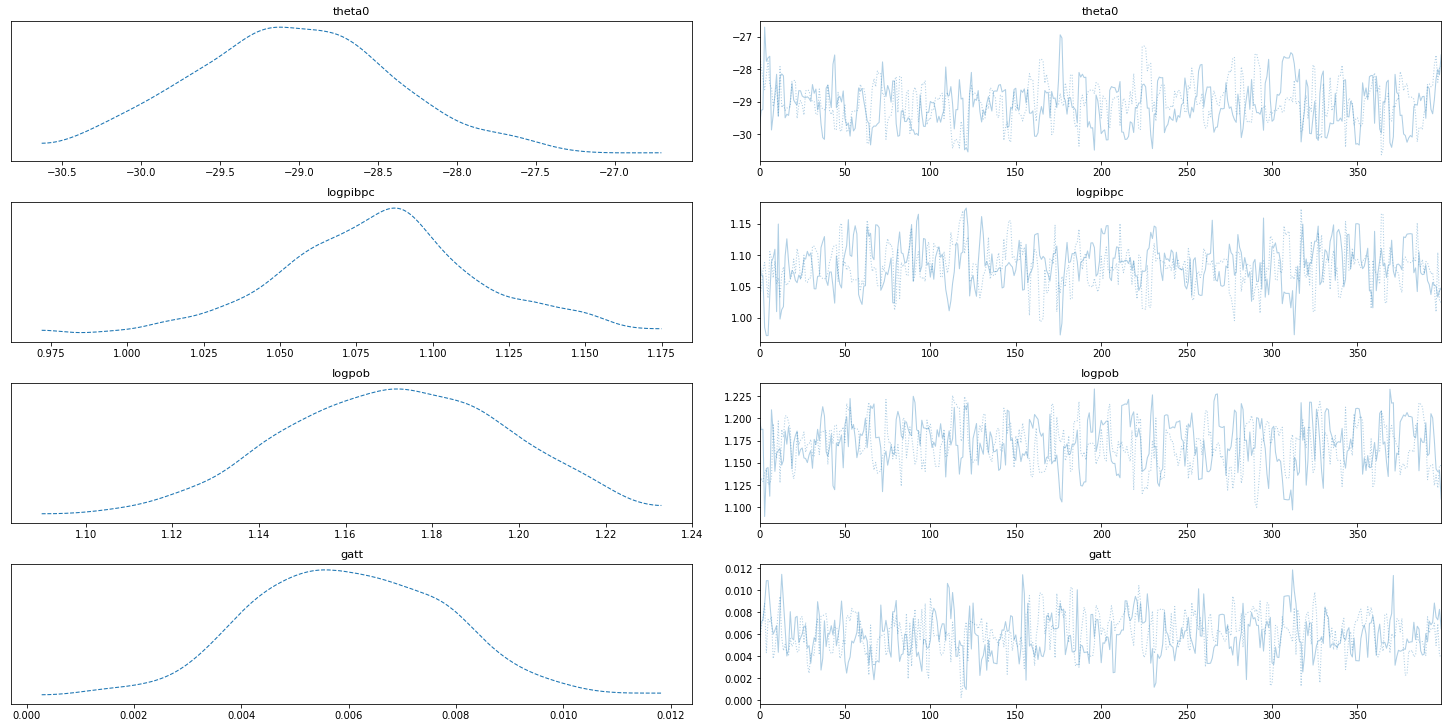

In [135]:
pm.traceplot(trace, figsize=(20, 10), var_names=['theta0', 'logpibpc', 'logpob', 'gatt'], combined=True);

### Muestras efectivo: 
Respecto a las muestras efectivo, el resultado que lo identifica ess_bulk demuestra ser confiable para medir la eficiencia de muestreo en la mayor parte de la distribución, ya que, sus valores no descienden de 200.
### Gelman-Rubin:
El diagnóstico de convergencia visto en el estadístico r_hat demuestra que las estimaciones entre y dentro de la cadena se han mezclado bien. Los resultados de r_hat varían entre 1.00 y 1.02.
### Función de autocorrelación:
Los parámetros comienzan regular, sin embargo, tardan muy poco en ajustarse, por lo que tienden a lograr valores cercanos a la convergencia

In [136]:
pm.summary(trace, var_names=['theta0', 'logpibpc', 'logpob', 'gatt']).round(3)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta0,-29.041,0.655,-30.299,-27.815,0.040,0.029,271.0,245.0,1.01
logpibpc,1.083,0.034,1.023,1.154,0.002,0.001,327.0,328.0,1.01
logpob,1.171,0.026,1.126,1.219,0.002,0.001,291.0,343.0,1.02
gatt,0.006,0.002,0.003,0.010,0.000,0.000,321.0,386.0,1.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5885ceef50>,
      dtype=object)

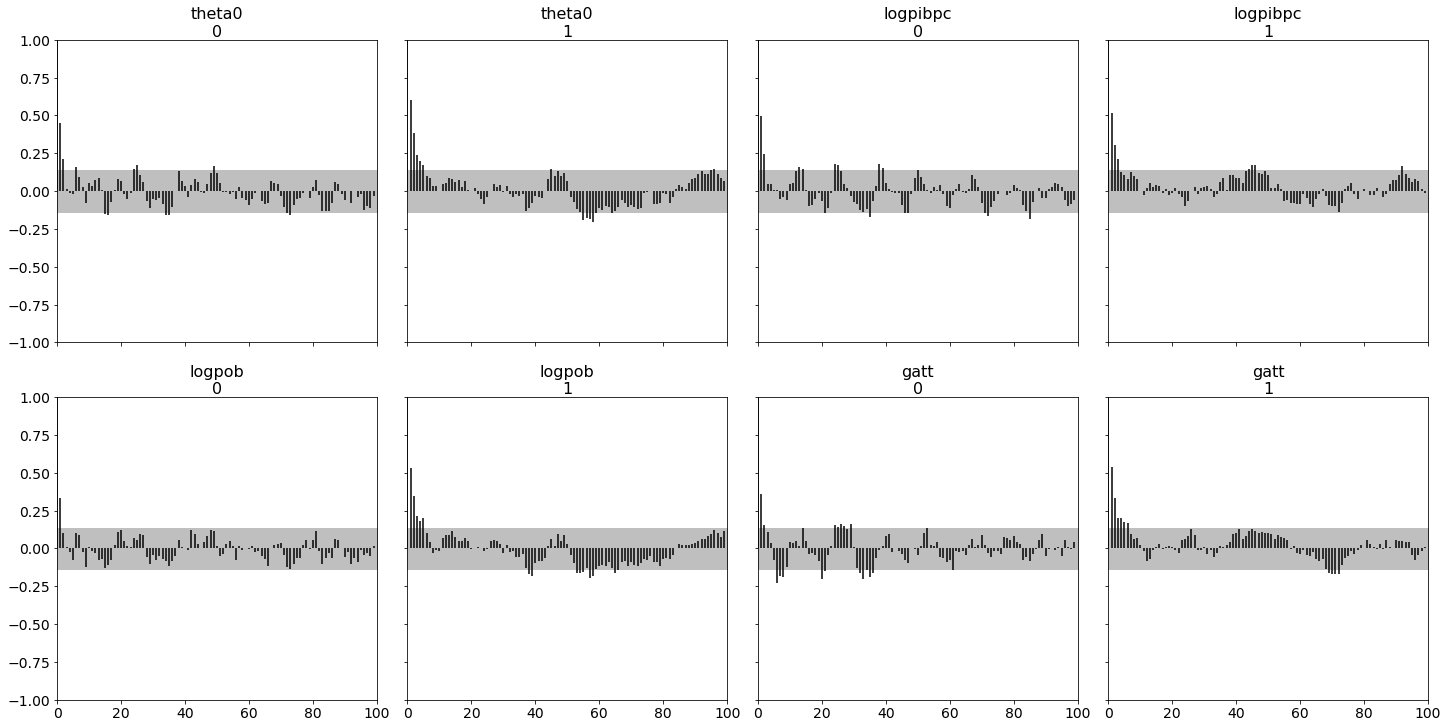

In [55]:
pm.plots.autocorrplot(trace, figsize=(20, 10), var_names=['theta0', 'logpibpc', 'logpob', 'gatt'])


In [96]:
with funcion_poisson:
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=100, var_names=['poiss' , 'mu', 'theta0', 'logpibpc', 'logpob', 'gatt'])
prediccion = posterior_predictive["poiss"][0]

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


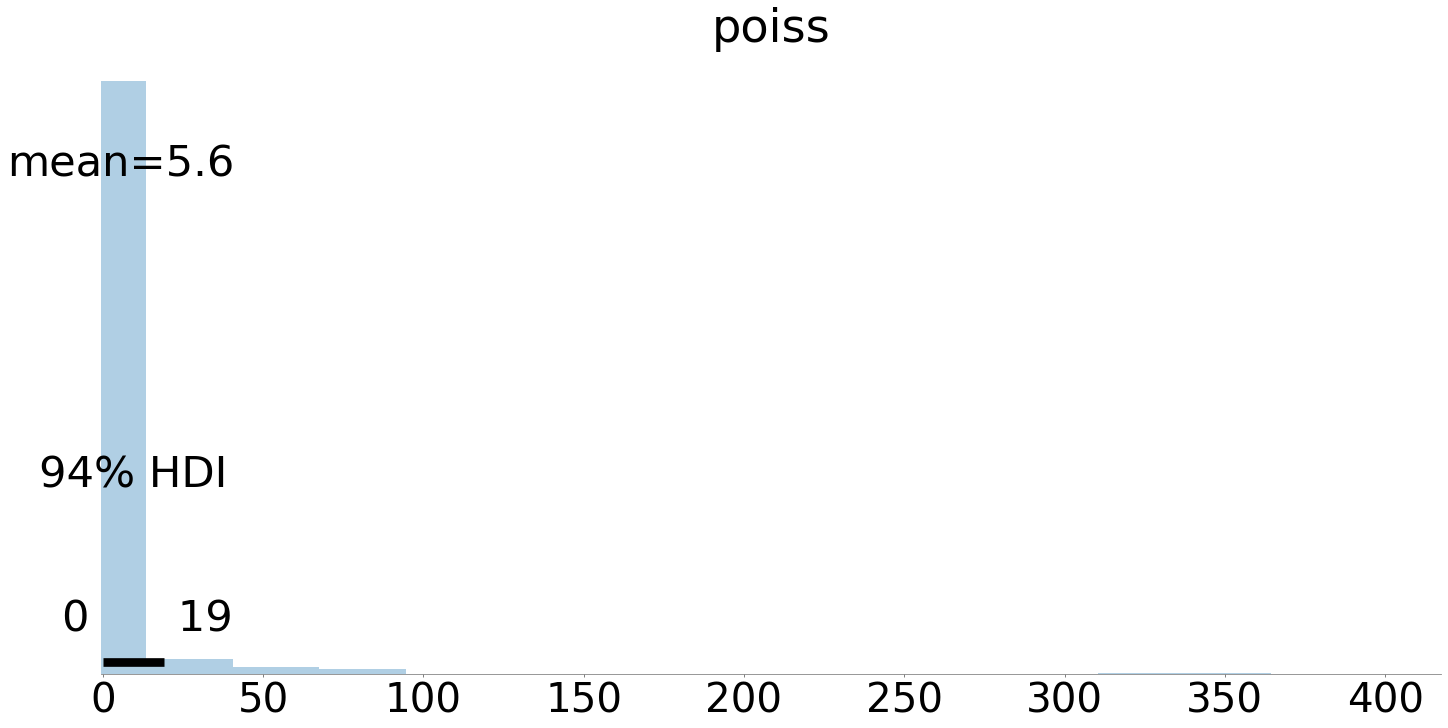

In [97]:
pm.plot_posterior(posterior_predictive, figsize=(20, 10), var_names=['poiss']);

# Entrenamiento con Metropolis

In [51]:
with funcion_poisson:
  trace_metropolis = pm.sample(draws=50000, tune=6000, chains=2, cores=4, step=pm.Metropolis(target_accept=.99))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [gatt]
>Metropolis: [logpob]
>Metropolis: [logpibpc]
>Metropolis: [theta0]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 6_000 tune and 50_000 draw iterations (12_000 + 100_000 draws total) took 99 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


### Trazas de los parámetros utilizando Metropolis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


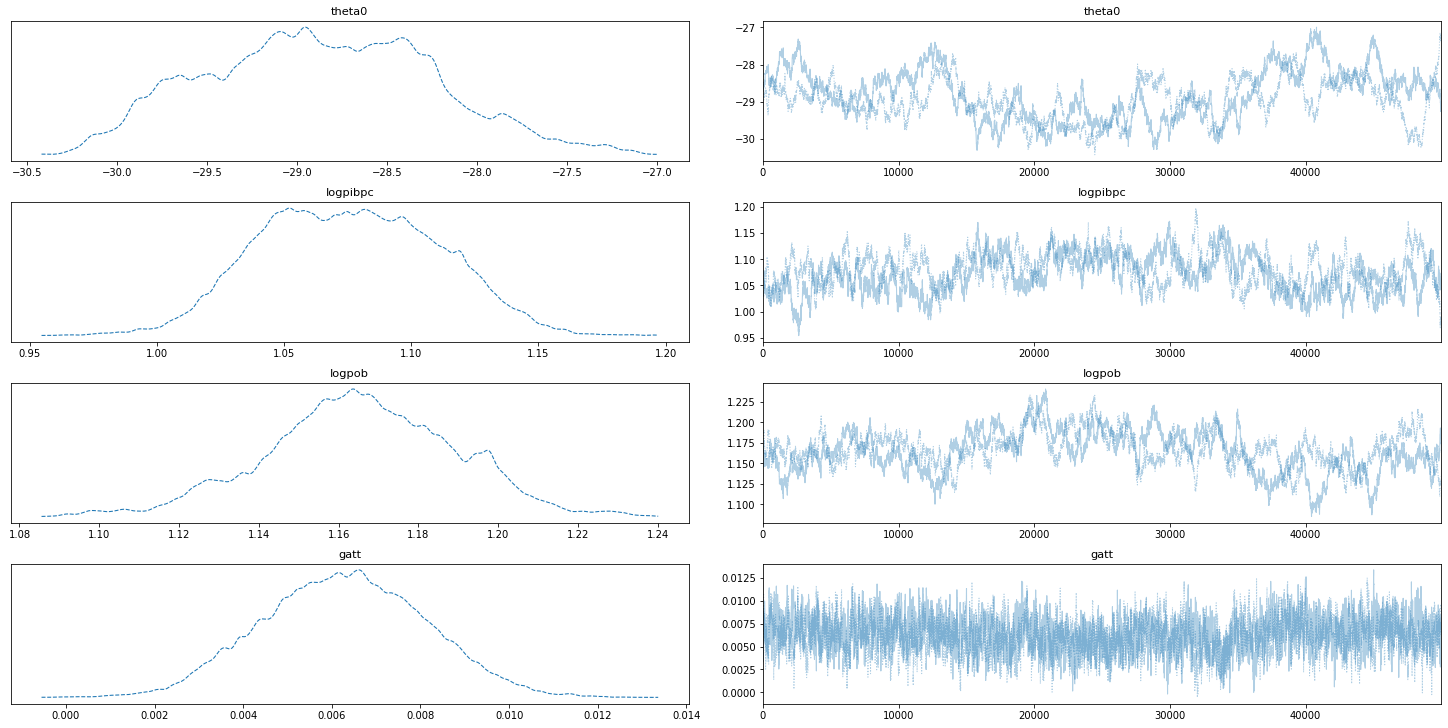

In [52]:
pm.traceplot(trace_metropolis, figsize=(20, 10), var_names=['theta0', 'logpibpc', 'logpob', 'gatt'], combined=True);

### Muestras efectivo: 
Respecto a las muestras efectivo, el resultado que lo identifica ess_bulk demuestra no ser confiable para medir la eficiencia de muestreo en la mayor parte de la distribución, ya que, sus valores varían entre 34 y 86 para las variables theta0, logpicpb, logpob, sin embargo, la variable gatt demuestra ser confiable al alcanzar un resultado superior a 400. La hipótesis sostenida es que el hiperparámetro "tune" es muy alto, ya que se desean ignorar valores atípicos registrados al modificar hiperparámetros.
### Gelman-Rubin:
El diagnóstico de convergencia visto en el estadístico r_hat demuestra que las estimaciones entre y dentro de la cadena se han mezclado bien. Los resultados de r_hat varían entre 1.00 y 1.03.
### Función de autocorrelación:
Se puede decir que las variables son altamente dependientes y a medida que el algoritmo avanza, no se logra la convergencia.

In [56]:
pm.summary(trace_metropolis, var_names=['theta0', 'logpibpc', 'logpob', 'gatt']).round(3)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta0,-28.872,0.627,-30.009,-27.743,0.126,0.090,25.0,115.0,1.03
logpibpc,1.075,0.035,1.014,1.139,0.006,0.004,35.0,207.0,1.03
logpob,1.166,0.024,1.120,1.208,0.004,0.003,30.0,133.0,1.03
gatt,0.006,0.002,0.003,0.010,0.000,0.000,252.0,1659.0,1.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58905e4950>,
      dtype=object)

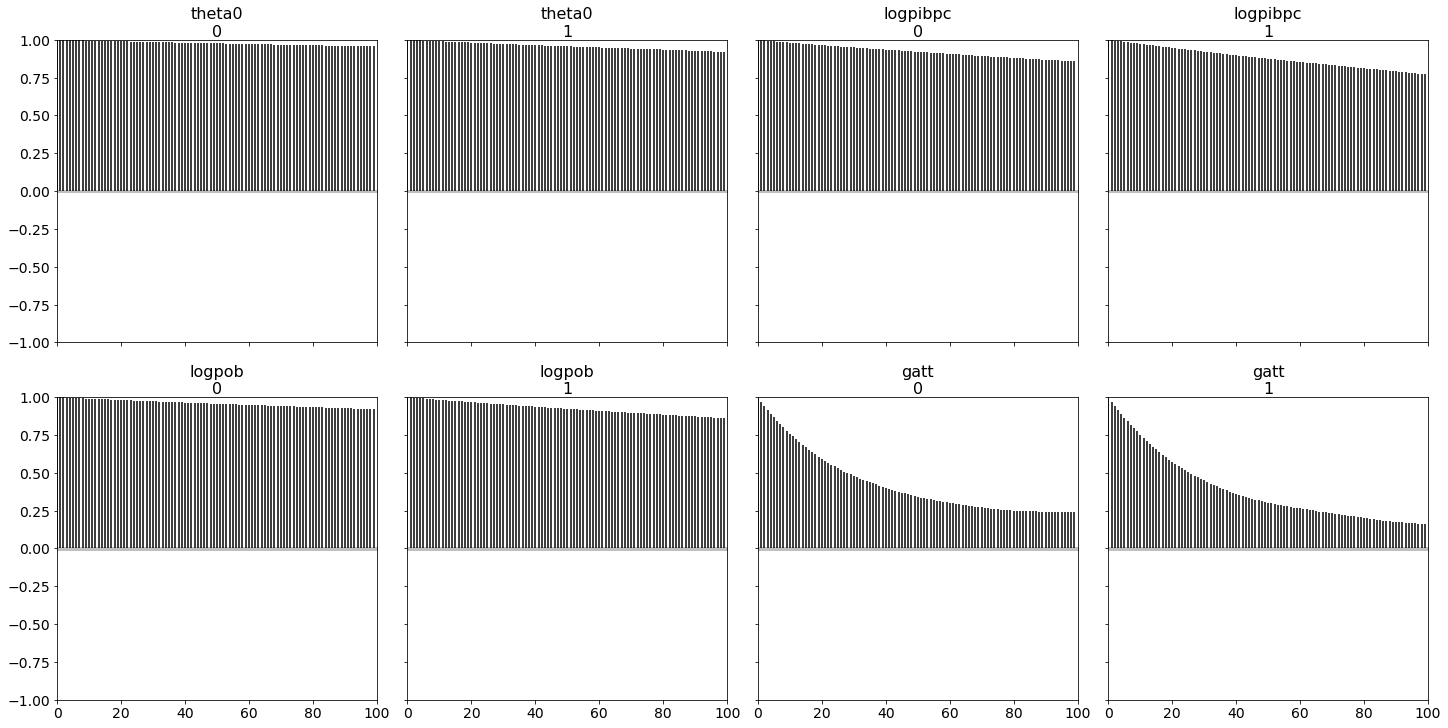

In [59]:
pm.plots.autocorrplot(trace_metropolis, figsize=(20, 10), var_names=['theta0', 'logpibpc', 'logpob', 'gatt'])

In [78]:
with funcion_poisson:
    posterior_predictive_2 = pm.sample_posterior_predictive(trace_metropolis, samples=100, var_names=['poiss' , 'mu', 'theta0', 'logpibpc', 'logpob', 'gatt'])
prediccion = posterior_predictive_2["poiss"][0]

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


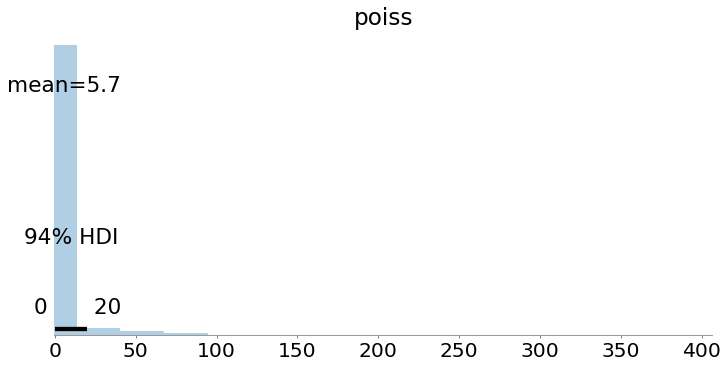

In [112]:
pm.plot_posterior(posterior_predictive_2, figsize=(10, 5), var_names=['poiss']);

### Medianas y percentiles

In [98]:
print("mediana de poiss: ",np.median(posterior_predictive["poiss"][0]))
print("mediana de mu: ", np.median(posterior_predictive["mu"]))
print("mediana de logpibpc: ",np.median(posterior_predictive["logpibpc"]))
print("mediana de logpob: ", np.median(posterior_predictive["logpob"]))
print("mediana de gatt: ", np.median(posterior_predictive["gatt"]))

mediana de poiss:  0.0
mediana de mu:  -1.8133208830816745
mediana de logpibpc:  1.0769010330609154
mediana de logpob:  1.165881641446438
mediana de gatt:  0.006057868226411718


##### Los Parámetros obtenidos con mediana significativamente distinto de cero son logpibpc y logpob. Esto está dado en base a la gran diferencia que existe entre los ingresos de países ricos y pobres.


- Prediga la cantidad de billonarios usando su modelo y la incertidumbre asociada (posterior predictivo). Muestre graficamente sus resultados
- ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?

In [123]:
#Predicción de billonarios por país
for j in range(0, 196):
  print("País :", datos["pais"][j], "predicción de billonarios", prediccion[j])
#prediccion

País : United States predicción de billonarios 374
País : Canada predicción de billonarios 16
País : Bahamas, The predicción de billonarios 0
País : Aruba predicción de billonarios 0
País : Bermuda predicción de billonarios 0
País : Cuba predicción de billonarios 1
País : Haiti predicción de billonarios 0
País : Dominican Republic predicción de billonarios 1
País : Jamaica predicción de billonarios 0
País : Trinidad and Tobago predicción de billonarios 0
País : Barbados predicción de billonarios 0
País : Dominica predicción de billonarios 0
País : Grenada predicción de billonarios 0
País : St. Lucia predicción de billonarios 0
País : St. Vincent and the Grenadines predicción de billonarios 0
País : Antigua and Barbuda predicción de billonarios 0
País : St. Kitts and Nevis predicción de billonarios 0
País : Mexico predicción de billonarios 11
País : Belize predicción de billonarios 0
País : Guatemala predicción de billonarios 0
País : Honduras predicción de billonarios 0
País : El Salva

In [124]:
#Países con mayor error de predicción
error = abs(prediccion - y.T)
for i in range(197):
  if (error[0][i] > 41):
    print("error de billonarios:", error[0][i],"país: ", datos["pais"][i])

error de billonarios: 95 país:  United States
error de billonarios: 42 país:  Italy
error de billonarios: 61 país:  Russian Federation
error de billonarios: 54 país:  China
error de billonarios: 66 país:  Japan


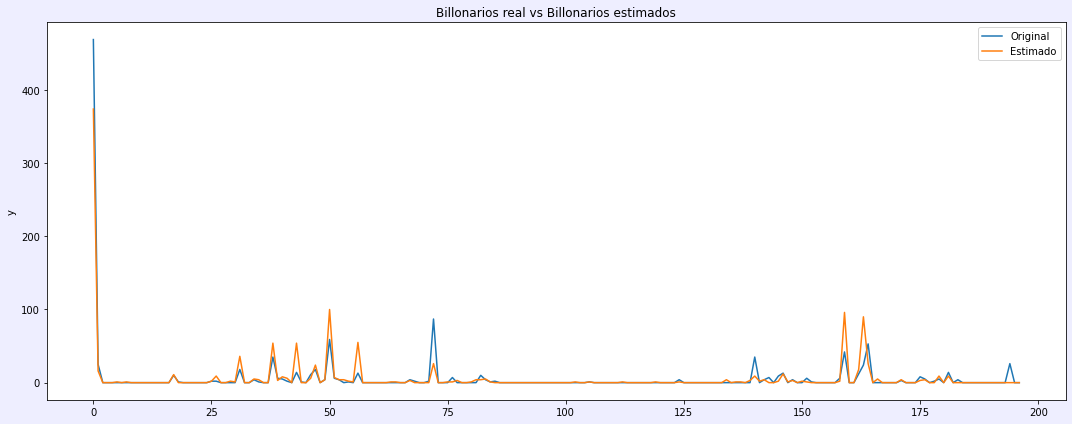

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True, facecolor='#EEF')
ax.plot(y, label = "Original")
ax.plot(prediccion, label = "Estimado")
ax.set_ylabel('y')
ax.set_title("Billonarios real vs Billonarios estimados")
ax.legend()






##### Países con exceso de billonarios





In [131]:
error = (posterior_predictive["poiss"][0] - y.T)

In [132]:
print("Paises con prediccion excesiva: ")
print("----------------------------------------------------------------------------")
for i in range(197):
  if (error[0][i] > 0):
    print("error: ", error[0][i], datos["pais"][i], " /// Cantidad real: ", datos["nbillonarios"][i], " Cantidad predicha: ", posterior_predictive["poiss"][0][i])
    #abs(posterior_predictive["poiss"][0] - y.T)/100
    porcentaje_error = (error[0][i]*(100)/(datos["nbillonarios"][i]))
    print("Porcentaje de error: ", porcentaje_error)

Paises con prediccion excesiva: 
----------------------------------------------------------------------------
error:  1 Cuba  /// Cantidad real:  0  Cantidad predicha:  1
Porcentaje de error:  inf
error:  1 Dominican Republic  /// Cantidad real:  0  Cantidad predicha:  1
Porcentaje de error:  inf
error:  1 Mexico  /// Cantidad real:  10  Cantidad predicha:  11
Porcentaje de error:  10.0
error:  7 Venezuela, RB  /// Cantidad real:  2  Cantidad predicha:  9
Porcentaje de error:  350.0
error:  2 Ecuador  /// Cantidad real:  0  Cantidad predicha:  2
Porcentaje de error:  inf
error:  1 Peru  /// Cantidad real:  0  Cantidad predicha:  1
Porcentaje de error:  inf
error:  18 Brazil  /// Cantidad real:  18  Cantidad predicha:  36
Porcentaje de error:  100.0
error:  1 Chile  /// Cantidad real:  4  Cantidad predicha:  5
Porcentaje de error:  25.0
error:  3 Argentina  /// Cantidad real:  1  Cantidad predicha:  4
Porcentaje de error:  300.0
error:  19 United Kingdom  /// Cantidad real:  35  Cantida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


##### Países con escasez de billonarios


In [133]:
# Paises con prediccion negativa:
print("Paises con prediccion negativa:")
for i in range(197):
  if (error[0][i] < 0):
    print("error: ", error[0][i], datos["pais"][i], " /// Cantidad real: ", datos["nbillonarios"][i], " Cantidad predicha: ", posterior_predictive["poiss"][0][i])
    #abs(posterior_predictive["poiss"][0] - y.T)/100
    porcentaje_error = (error[0][i]*(100)/(datos["nbillonarios"][i]))
    print("Porcentaje de error: ", porcentaje_error)


Paises con prediccion negativa:
error:  -95 United States  /// Cantidad real:  469  Cantidad predicha:  374
Porcentaje de error:  -20.255863539445627
error:  -9 Canada  /// Cantidad real:  25  Cantidad predicha:  16
Porcentaje de error:  -36.0
error:  -1 Belize  /// Cantidad real:  1  Cantidad predicha:  0
Porcentaje de error:  -100.0
error:  -3 Ireland  /// Cantidad real:  6  Cantidad predicha:  3
Porcentaje de error:  -50.0
error:  -1 Monaco  /// Cantidad real:  1  Cantidad predicha:  0
Porcentaje de error:  -100.0
error:  -5 Switzerland  /// Cantidad real:  11  Cantidad predicha:  6
Porcentaje de error:  -45.45454545454545
error:  -1 Greece  /// Cantidad real:  4  Cantidad predicha:  3
Porcentaje de error:  -25.0
error:  -2 Cyprus  /// Cantidad real:  2  Cantidad predicha:  0
Porcentaje de error:  -100.0
error:  -2 Romania  /// Cantidad real:  2  Cantidad predicha:  0
Porcentaje de error:  -100.0
error:  -61 Russian Federation  /// Cantidad real:  87  Cantidad predicha:  26
Porcenta

#### Rusia es el país mas afectado, al poseer una cantidad de billonarios igual a 87, sin embargo, se predijo solo 26, lo que se traduce en una diferencia de ~300% de disminución de billonarios. Esta información nos permite concluir que existen otros parámetros además de pib, pob y gatt que pueden influir en la cantidad de billonarios de un país. 